# Two-point Greedy Optimizer

This notebook explores the `PySensors` Two-point Greedy Optimizer `TPGR` for sparse sensor placement for reconstruction. 

For $p$ sensors and $r$ basis modes, while the `QR` optimizer returned exactly $p=r$ sensors in order of decreasing importance through pivoting and placed any subsequent sensors randomly, a `TPGR` optimizer can return a user specified $p$ sensors for any number of basis modes $r$.

See the following reference for more information on Two-Point Greedy Optimizer and Regularized Least Squares Reconstruction ([link](https://arxiv.org/pdf/2307.11838))

`Klishin, Andrei A., J. Nathan Kutz and Krithika Manohar. Data-Induced Interactions of Sparse Sensors. 2023. arXiv:2307.11838 [cond-mat.stat-mech]`

In [1]:
from ftplib import FTP
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.pyplot as plt
import numpy as np
import netCDF4

import pysensors as ps

Import Data

In [2]:
ftp = FTP('ftp.cdc.noaa.gov')
ftp.login()
ftp.cwd('/Datasets/noaa.oisst.v2/')

filenames = ['sst.wkmean.1990-present.nc', 'lsmask.nc']

for filename in filenames:
    localfile = open(filename, 'wb')
    ftp.retrbinary('RETR ' + filename, localfile.write, 1024)
    localfile.close()

ftp.quit();

In [3]:
f = netCDF4.Dataset('sst.wkmean.1990-present.nc')

lat,lon = f.variables['lat'], f.variables['lon']
SST = f.variables['sst']
sst = SST[:]

f = netCDF4.Dataset('lsmask.nc')
mask = f.variables['mask']

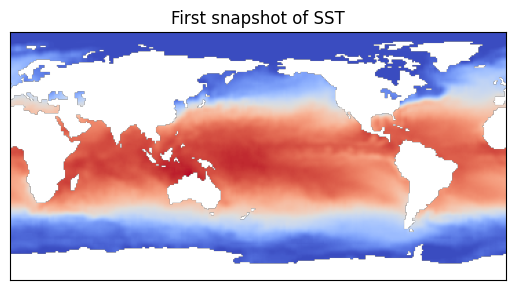

In [4]:
masks = np.bool_(np.squeeze(mask))
snapshot = float("nan")*np.ones((180,360))
snapshot[masks] = sst[0,masks]

plt.imshow(snapshot, cmap=plt.cm.coolwarm)
plt.colorbar
plt.xticks([])
plt.yticks([])
plt.title('First snapshot of SST')
X = sst[:,masks]
X = np.reshape(X.compressed(), X.shape) # convert masked array to array

In [5]:
r=100
flat_prior = np.full(r, 1000)
X_train = X[:1300, :]
X_test = X[1300:, :]

Change the prior to either a flat prior or decreasing prior

In [6]:
prior = flat_prior
# prior='decreasing'

In [7]:
model = ps.SSPOR(
    basis=ps.basis.SVD(n_basis_modes=r),
    optimizer=ps.optimizers.TPGR(n_sensors=25, noise=1, prior=prior)
)
model.fit(X_train)
sensors = model.get_selected_sensors()

print(model.basis_matrix_.shape)
print(model.singular_values.shape)

(44219, 100)
(100,)


Plot the learned sensor locations using the `TPGR` optimizer

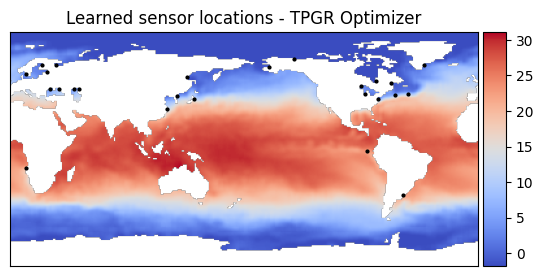

In [8]:
temp = np.transpose(0 * X[1,:])
temp[sensors] = 1
img = 0*snapshot
img[masks] = temp
image = plt.imshow(snapshot, cmap=plt.cm.coolwarm)
indx = np.where(img==1)
plt.scatter(indx[1], indx[0], 4, color='black')
ax = plt.gca()
plt.xticks([])
plt.yticks([])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(image, cax)
ax.set_title('Learned sensor locations - TPGR Optimizer');

Reconstruct using Regularized Least Squares Reconstruction

In [9]:
x_test = X_test[:, sensors]
predicted_state = model.predict(x_test, noise=1, prior=prior)

Compute and plot the Uncertainty Heatmap

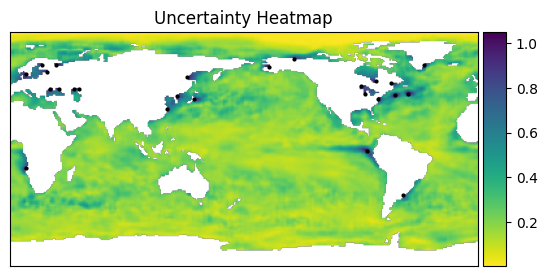

In [10]:
sigma = model.std(prior=prior, noise=1)

temp1 = np.transpose(0 * X[1,:])
temp2=temp1
temp1[:] = sigma
temp2[sensors]=1
img = 0*snapshot
img2=img
img2[masks] = temp2
indx = np.where(img2==1)
plt.figure()
plt.scatter(indx[1], indx[0], 4, color='black')
ax = plt.gca()
image = ax.imshow(img, cmap=plt.cm.viridis_r)
plt.xticks([])
plt.yticks([])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(image, cax)
ax.set_title('Uncertainty Heatmap');

Compute and plot One-Point Energy Landscape

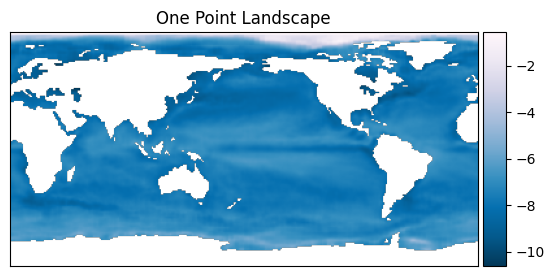

In [11]:
one_pt_landscape = model.one_pt_energy_landscape(prior=prior, noise=1)

temp = np.transpose(0 * X[1,:])
temp[:] = one_pt_landscape
img = 0*snapshot
img[masks] = temp
plt.figure()
image = plt.imshow(img, cmap=plt.cm.PuBu_r)
ax = plt.gca()
plt.xticks([])
plt.yticks([])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(image, cax)
ax.set_title('One Point Landscape');

Print sensor locations

In [12]:
print(type(sensors))

<class 'list'>


Compute and plot two-point energy landscape.
When the input to `two_pt_sensors` is multiple sensors, the resulting landscape is the sum of two point interactions with all of those sensors. If the input is a single sensor, the resulting landscape will be the two point interaction with that particular sensor. 

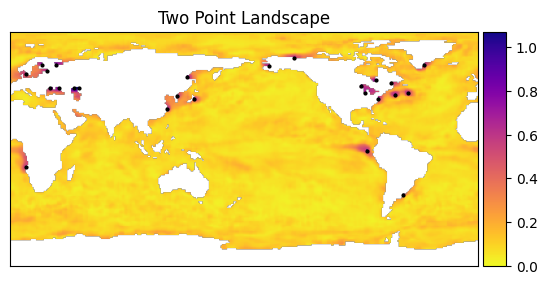

In [13]:
two_pt_sensors = sensors
# two_pt_sensors = [9663]
two_pt_landscape = model.two_pt_energy_landscape(selected_sensors=two_pt_sensors, prior=prior, noise=1)

temp1 = np.transpose(0 * X[1,:])
temp2=temp1
temp1[:] = two_pt_landscape
temp2[two_pt_sensors] = 1
img1 = 0*snapshot
img2=img1
img1[masks] = temp1
img2[masks] = temp2
image = plt.imshow(img1,
            cmap=plt.cm.plasma_r,
            vmax=np.nanmax(two_pt_landscape),
            vmin=0,
            )
ax = plt.gca()
indx = np.where(img2==1)
plt.scatter(indx[1], indx[0], 4, color='black')
plt.xticks([])
plt.yticks([])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(image, cax)
ax.set_title('Two Point Landscape');